## Linear Regression with Gradient Descent

Linear regression problem solved with stochastic gradient descent algorithm.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset
Dataset consists of data from 145 5-dimensional data points. Each data point represents an American power supply firm. The dimensions are:
* **TC**: Total cost
* **Q**: Output
* **PL**: Price of labor
* **PF**: Price of fuel
* **PK**: Price of capital

The dataset is from the year 1955.

In [3]:
# Read data set
df = pd.read_csv('nerlove.csv')
print('Shape of the dataset:', df.shape)
print('Number of missing values:', df.isna().sum().sum())
df.head()

Shape of the dataset: (145, 5)
Number of missing values: 0


,TC,Q,PL,PF,PK
0,0.082,2,2.09,17.9,183
1,0.661,3,2.05,35.1,174
2,0.990,4,2.05,35.1,171
3,0.315,4,1.83,32.2,166
4,0.197,5,2.12,28.6,233


### Problem formulation

Let's assume that the output of each firm, $Q$, can be derived from the following production 
function: </br>
$Q = F(L, F, K)$ </br>
If we assume a Cobb-Douglas technology, the production function would be: </br>
$F(L, F, K) ) = A \cdot L^\alpha \cdot F^\beta \cdot K^\gamma$ where $\alpha + \beta + \gamma = r$
and $A$ is the technology level of the firm. </br>

Thus the total cost function of a firm would be:
$TC = r \cdot (A \cdot \alpha^\alpha \beta^\beta \gamma^\gamma)^{-1/r} \cdot Q^{1/r} \cdot 
P_L^{\alpha/r} P_F^{\beta/r} P_K^{\gamma/r}$ </br>

From this, we can derive a log-log model: </br>
$loc(TC) = \mu + \dfrac{1}{r}log(Q) + \dfrac{\alpha}{r}log(P_L) + \dfrac{\beta}{r}log(P_F) + \dfrac{\gamma}{r}log(P_K)$ where $\mu$ is $log(A \cdot \alpha^\alpha \beta^\beta \gamma^\gamma)^{-1/r}$

From this, we get a linear regression model: </br>
$log(TC) = \beta + w_1 \cdot log(Q) + w_2 \cdot log(P_L) + w_3 \cdot log(P_F) + w_4 \cdot log(P_K) + \epsilon$

log(TC) (y-axis) vs. log(Q), log(PL), log(PF) & log(PK) (x-axis)


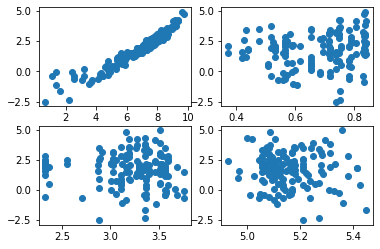

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2)

response_vars = [np.log(df['Q']), np.log(df['PL']), np.log(df['PF']), np.log(df['PK'])]

idx = 0
for row in ax:
    for col in row:
        col.scatter(response_vars[idx], np.log(df['TC']))
        idx += 1
print('log(TC) (y-axis) vs. log(Q), log(PL), log(PF) & log(PK) (x-axis)')
plt.show()

### Data to tensors

In [5]:
# Pandas to numpy
X = df[['Q', 'PL', 'PF', 'PK']].to_numpy()
X = np.log(X)
y = df['TC'].to_numpy()
y = np.log(y)
y = np.expand_dims(y, axis=1)

print(X.shape, y.shape)

(145, 4) (145, 1)


In [13]:
# Splitting the dataset
np.random.seed(0)

n = df.shape[0]
idx = np.arange(n)
np.random.shuffle(idx)
train_idx = idx[:int(0.8*n)]
test_idx = idx[int(0.8*n):]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(116, 4) (116, 1) (29, 4) (29, 1)


In [25]:
X_train_t = torch.as_tensor(X_train).float().to(device)
y_train_t = torch.as_tensor(y_train).float().to(device)
print(X_train_t.size(), y_train_t.size())

torch.Size([116, 4]) torch.Size([116, 1])


### Training the model

$log(TC) = \beta + w_1 \cdot log(Q) + w_2 \cdot log(P_L) + w_3 \cdot log(P_F) + w_4 \cdot log(P_K) + \epsilon$


In [111]:
# Hypoerparameter initialization
lr = 0.01
n_epochs = 100

# Parameter initialization
torch.manual_seed(0)

# Linear model
dim = X_train.shape[1]
model = nn.Sequential(nn.Linear(in_features=dim, out_features=1, bias=True)).to(device)
#model = LinReg().to(device)

# Optimizer & loss
opt = optim.SGD(model.parameters(), lr=lr)
mse = nn.MSELoss(reduction='mean')

In [112]:
# Loss tracking
loss_track = np.zeros(n_epochs)

# Training
for epoch in range(n_epochs):
    model.train()
    y_hat_t = model(X_train_t)
    loss = mse(y_hat_t, y_train_t)
    loss_track[epoch] = loss
    if epoch == n_epochs-1 or epoch % 10 == 0:
        print('Loss:', loss, 'Epoch:', epoch)
    loss.backward()
    opt.step()
    opt.zero_grad()
print(model.state_dict())

Loss: tensor(26.2105, grad_fn=<MseLossBackward0>) Epoch: 0
Loss: tensor(0.3957, grad_fn=<MseLossBackward0>) Epoch: 10
Loss: tensor(0.3158, grad_fn=<MseLossBackward0>) Epoch: 20
Loss: tensor(0.2799, grad_fn=<MseLossBackward0>) Epoch: 30
Loss: tensor(0.2622, grad_fn=<MseLossBackward0>) Epoch: 40
Loss: tensor(0.2529, grad_fn=<MseLossBackward0>) Epoch: 50
Loss: tensor(0.2474, grad_fn=<MseLossBackward0>) Epoch: 60
Loss: tensor(0.2436, grad_fn=<MseLossBackward0>) Epoch: 70
Loss: tensor(0.2407, grad_fn=<MseLossBackward0>) Epoch: 80
Loss: tensor(0.2381, grad_fn=<MseLossBackward0>) Epoch: 90
Loss: tensor(0.2360, grad_fn=<MseLossBackward0>) Epoch: 99
OrderedDict([('0.weight', tensor([[ 0.6729,  0.2949, -0.2482, -0.3662]])), ('0.bias', tensor([-0.1926]))])


Text(0.5, 1.0, 'MSE over 100 epochs')

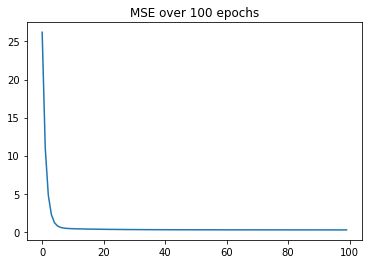

In [113]:
plt.plot(np.arange(n_epochs), loss_track)
plt.title(f'MSE over {n_epochs} epochs')

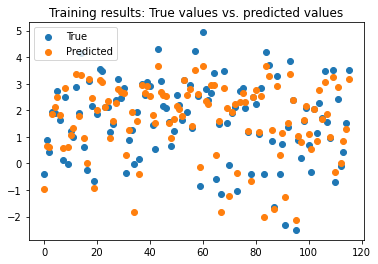

In [135]:
y_hat = y_hat_t.detach().numpy()
#print(y_train)
plt.scatter(np.arange(len(y_train)), y_train, label='True')
plt.scatter(np.arange(len(y_train)), y_hat, label='Predicted')
plt.legend(loc="upper left")
plt.title('Training results: True values vs. predicted values')
plt.show()

### Sources
Dataset: http://fhayashi.fc2web.com/datasets.htm </br>
Problem formulation: F. Hayashi: Econometrics (2000) </br>